In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import milopy  
import milopy.core as milo
from community import community_louvain
import networkx as nx

In [22]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

In [3]:
def write_deres(excel_path, adata, group, de_key):
    # writing results to excel file
    res_cat = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']

    writer = pd.ExcelWriter(excel_path, engine='xlsxwriter')

    for g in group:
        d = {res_cat[0]: adata.uns[de_key][res_cat[0]][str(g)].tolist(),
             res_cat[1]: adata.uns[de_key][res_cat[1]][str(g)].tolist(),
             res_cat[2]: adata.uns[de_key][res_cat[2]][str(g)].tolist(),
             res_cat[3]: adata.uns[de_key][res_cat[3]][str(g)].tolist(),
             res_cat[4]: adata.uns[de_key][res_cat[4]][str(g)].tolist()
             }
        df = pd.DataFrame(data=d)
        df.to_excel(writer, sheet_name=str(g))

    writer.save()

In [4]:
def plot_genes_bootstrap(adata, cc_geneset, cat_order, meta_slot, bar_colors, y_max):
    for gene_name in cc_geneset:
        dat = np.array(adata[:, gene_name].X.todense()).flatten()
        dat_stat = np.zeros((len(np.unique(adata.obs[meta_slot])), 3))
        dat_stat2 = np.zeros((len(np.unique(adata.obs[meta_slot])), 3))
        b = 0

        for g in cat_order:
            i = np.where(adata.obs[meta_slot] == g)[0]
            ci_info = bs.bootstrap(dat[i], stat_func=bs_stats.mean)
            dat_stat[b, 0] = ci_info.value
            dat_stat2[b, 0] = ci_info.value
            dat_stat[b, 1] = dat_stat[b, 0] - ci_info.lower_bound
            dat_stat2[b, 1] = ci_info.lower_bound
            dat_stat[b, 2] = ci_info.upper_bound - dat_stat[b, 0]
            dat_stat2[b, 2] = ci_info.upper_bound
            b = b + 1

        # plotting results as bar graphs
        fig, ax = plt.subplots(figsize=(4, 5))
        bar_ind = cat_order
        barlist = ax.bar(bar_ind, dat_stat[:, 0], yerr=[dat_stat[:, 1], dat_stat[:, 2]], align='center', ecolor='black',
                         capsize=10, color=bar_colors)
        plt.title(gene_name)
        ax.set_ylabel('ln[mRNA counts + 1]')
        ax.set_xticks(np.arange(len(bar_ind)))
        ax.set_xticklabels(bar_ind, rotation=75)
        plt.ylim([0, y_max])
        # plt.tight_layout()

        return dat_stat2

In [5]:
import itertools
from distinctipy import distinctipy

In [6]:
def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash'][z])
            if adata.obs['sample'][z] == 'BD1':
                rep[z] = rep_dict[z_arg]
            else:
                rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep


def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep


def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood


def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')


In [7]:
sc.set_figure_params(figsize=(4, 4), fontsize=20)
celltype_dict = {'Basophil': sns.color_palette('tab20', 20)[0],
                 'CCR7+ DC': sns.color_palette('tab20', 20)[2],
                 'CD4+ T cell': sns.color_palette('tab20', 20)[4],
                 'CD8+ T cell': sns.color_palette('tab20', 20)[6],
                 'Fibroblast': sns.color_palette('tab20', 20)[8],
                 'Fibroblast 2': sns.color_palette('tab20', 20)[9],
                 'Macrophage': sns.color_palette('tab20', 20)[10],
                 'Macrophage 2': sns.color_palette('tab20', 20)[11],
                 'Macrophage 3': sns.color_palette('tab20', 20)[13],
                 'Cd3+ Macrophage': sns.color_palette('tab20', 20)[17],
                 'Chil3+ Mac': 'xkcd:grey',
                 'Cx3cr1+ Mac': sns.color_palette('tab20', 20)[19],
                 'Mrc1+ Macrophage': sns.color_palette('tab20b', 20)[0],
                 'cDC2': sns.color_palette('tab20b', 20)[4],
                 'mt-Macrophage': sns.color_palette('tab20', 20)[14],
                 'NK cell': sns.color_palette('tab20', 20)[12],
                 'Neutrophil': sns.color_palette('tab20', 20)[16],
                 'Poorly classified': 'xkcd:light grey',
                 'Mixed': 'xkcd:light grey',
                 'Treg': sns.color_palette('tab20', 20)[1],
                 'Tumor cell': sns.color_palette('tab20', 20)[3],
                 'XCR1+ DC': sns.color_palette('tab20', 20)[5]}

sample_dict = {'Ctrl d8': sns.husl_palette(5)[0],
               'CPI hi d8': sns.husl_palette(5)[1], 'CPI lo d8': sns.husl_palette(5)[2],
               'CD40ag d8': sns.husl_palette(5)[3], 'TTx d8': sns.husl_palette(5)[4]}


In [14]:
adata_d8 = sc.read('/Users/anasuyadighe/Downloads/cpi_cd40_d8_refined.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [15]:
adata_d8.obs['sample_cond']

AAACGGGAGCTAGTCT-1-BD2    Ctrl d8
AAAGATGAGCGATAGC-1-BD2    Ctrl d8
AAAGCAAGTCACCCAG-1-BD2    Ctrl d8
AAAGTAGAGAGAACAG-1-BD2    Ctrl d8
AAAGTAGAGTGGGCTA-1-BD2    Ctrl d8
                           ...   
TTTGTCATCAGTGCAT-1-BD6     TTx d8
TTTGTCATCCCGGATG-1-BD6     TTx d8
TTTGTCATCGACAGCC-1-BD6     TTx d8
TTTGTCATCTAACGGT-1-BD6     TTx d8
TTTGTCATCTGGTTCC-1-BD6     TTx d8
Name: sample_cond, Length: 8655, dtype: category
Categories (5, object): ['CD40ag d8', 'CPI hi d8', 'CPI lo d8', 'Ctrl d8', 'TTx d8']

In [16]:
type_annot = adata_d8.obs['nn_80'].values.tolist()
for i in np.where(adata_d8.obs['nn_refined'] == 'cDC2')[0]:
    type_annot[i] = 'cDC2'

adata_d8.obs['celltype'] = type_annot

In [17]:
adata_d8 = adata_d8[np.where(np.sum(adata_d8.obsm['hash'], axis=1) > 0)]
adata_d8 = remove_recompute(adata_d8)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3696809812.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsm['X_diffmap'], adata.obsp, adata.uns
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cur

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


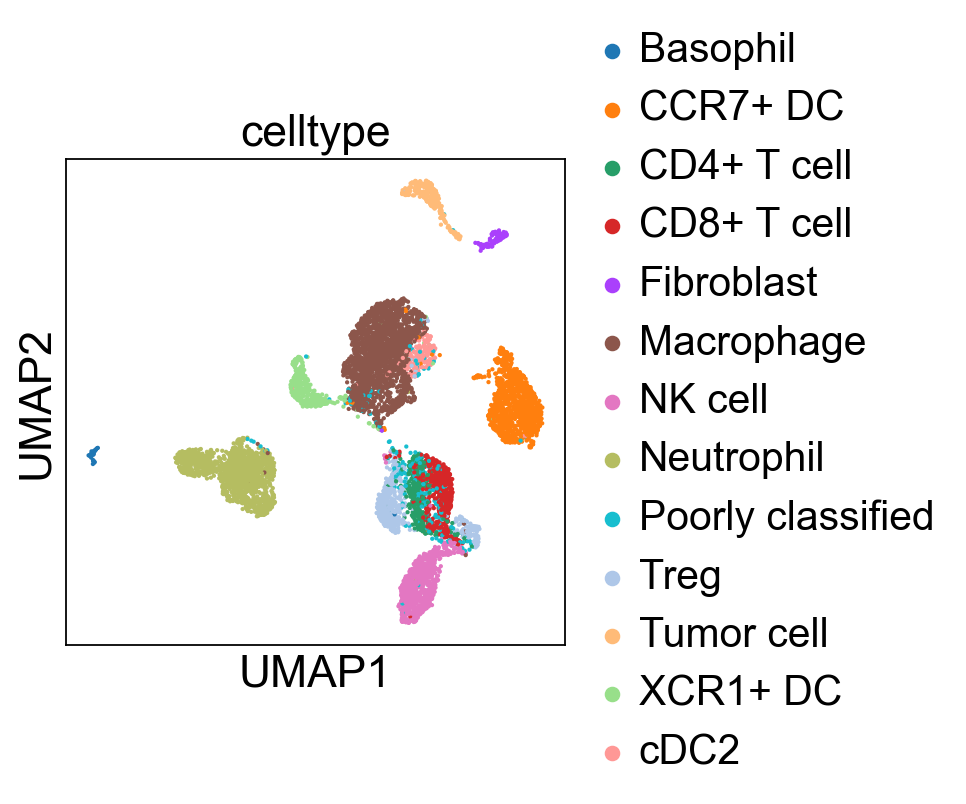

In [18]:
sc.pl.umap(adata_d8, color='celltype')

In [19]:
ctrld8_ind = np.where(adata_d8.obs['sample'] == 'BD2')[0]

In [20]:
ctrld8_ind

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [23]:
d8_pairs = []
for g in np.arange(3, 7):
    next_ind = np.where(adata_d8.obs['sample'] == 'BD{}'.format(g))[0]
    adatas = adata_d8[np.concatenate((ctrld8_ind, next_ind)), :]
    adatas = remove_recompute(adatas)
    d8_pairs.append(adatas.copy())

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3205555937.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3205555937.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3205555937.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3205555937.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], ad

In [26]:
d8_pairs[2].obs['sample_cond']

AAACGGGAGCTAGTCT-1-BD2      Ctrl d8
AAAGATGAGCGATAGC-1-BD2      Ctrl d8
AAAGCAAGTCACCCAG-1-BD2      Ctrl d8
AAAGTAGAGAGAACAG-1-BD2      Ctrl d8
AAAGTAGAGTGGGCTA-1-BD2      Ctrl d8
                            ...    
TTTGGTTCACCGGAAA-1-BD5    CPI lo d8
TTTGGTTGTATTACCG-1-BD5    CPI lo d8
TTTGGTTGTTCCCTTG-1-BD5    CPI lo d8
TTTGGTTGTTGCTCCT-1-BD5    CPI lo d8
TTTGGTTTCACAACGT-1-BD5    CPI lo d8
Name: sample_cond, Length: 2610, dtype: category
Categories (2, object): ['CPI lo d8', 'Ctrl d8']

In [27]:
cpi = d8_pairs[2].concatenate(adata_d8[np.where(adata_d8.obs['sample'] == 'BD4')])
cpi = remove_recompute(cpi)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [28]:
cpi.obs['sample_cond']

AAACGGGAGCTAGTCT-1-BD2-0      Ctrl d8
AAAGATGAGCGATAGC-1-BD2-0      Ctrl d8
AAAGCAAGTCACCCAG-1-BD2-0      Ctrl d8
AAAGTAGAGAGAACAG-1-BD2-0      Ctrl d8
AAAGTAGAGTGGGCTA-1-BD2-0      Ctrl d8
                              ...    
TTTGTCACAGTGAGTG-1-BD4-1    CPI hi d8
TTTGTCAGTAAATGTG-1-BD4-1    CPI hi d8
TTTGTCAGTACCGTTA-1-BD4-1    CPI hi d8
TTTGTCAGTTCCTCCA-1-BD4-1    CPI hi d8
TTTGTCATCTAACTTC-1-BD4-1    CPI hi d8
Name: sample_cond, Length: 4497, dtype: category
Categories (3, object): ['CPI hi d8', 'CPI lo d8', 'Ctrl d8']

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


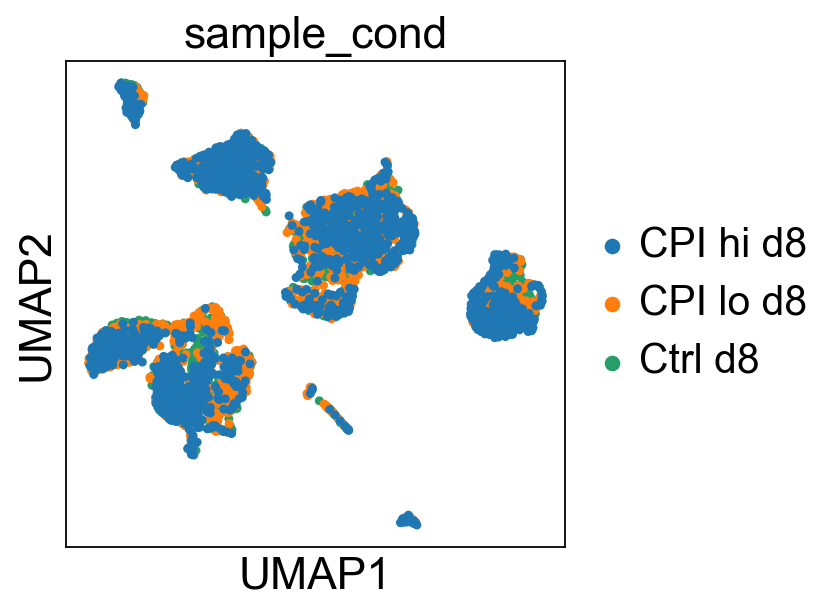

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


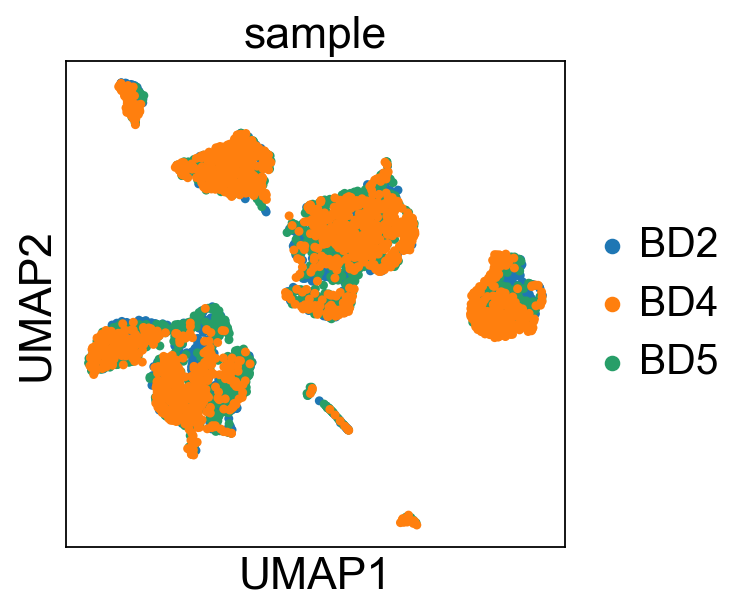

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


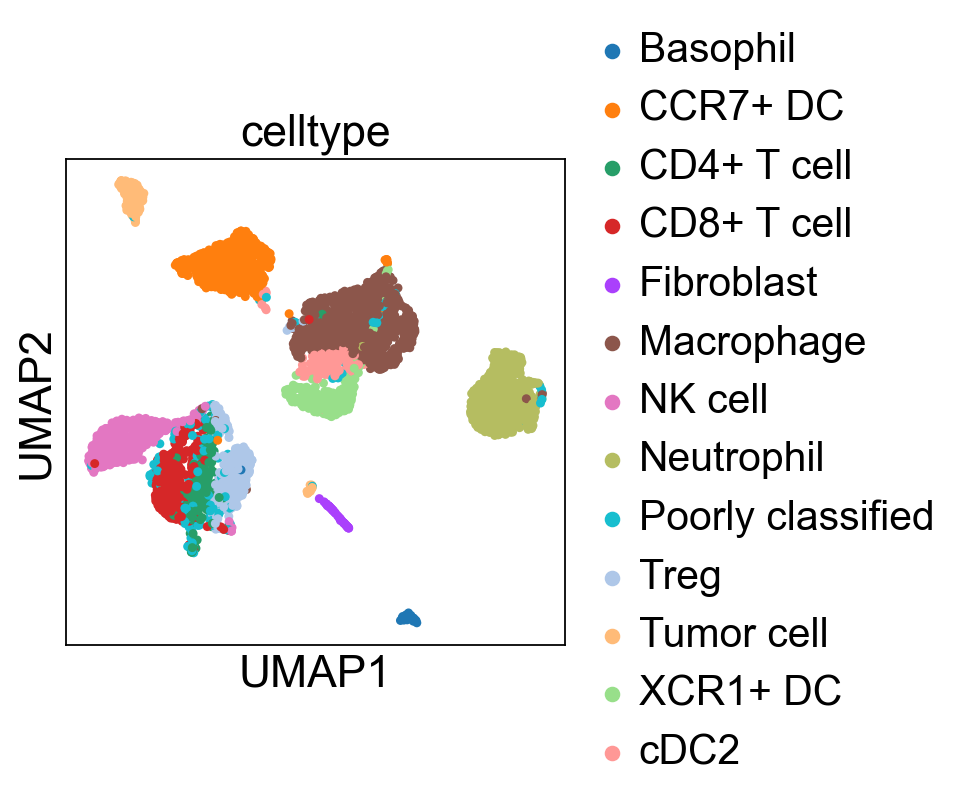

In [30]:
sc.pl.umap(cpi, color='sample_cond', s=65)
sc.pl.umap(cpi, color='sample', s=65)
sc.pl.umap(cpi, color='celltype', s=65)
#sc.pl.stacked_violin(cpi, ['Pdcd1', 'Ctla4'], groupby='celltype', swap_axes=True, dendrogram=True)

In [31]:
cpi.obs['replicate'] = encode_replicates(cpi, None)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/828529630.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs['sample'][z] == 'BD1':


In [32]:
cpi.obs['replicate']

AAACGGGAGCTAGTCT-1-BD2-0    R4
AAAGATGAGCGATAGC-1-BD2-0    R4
AAAGCAAGTCACCCAG-1-BD2-0    R1
AAAGTAGAGAGAACAG-1-BD2-0    R2
AAAGTAGAGTGGGCTA-1-BD2-0    R3
                            ..
TTTGTCACAGTGAGTG-1-BD4-1    R3
TTTGTCAGTAAATGTG-1-BD4-1    R3
TTTGTCAGTACCGTTA-1-BD4-1    R1
TTTGTCAGTTCCTCCA-1-BD4-1    R1
TTTGTCATCTAACTTC-1-BD4-1    R3
Name: replicate, Length: 4497, dtype: object

In [33]:
dose_dict = {'Ctrl d8': 0,
             'CPI lo d8': 25,
             'CPI hi d8': 100}
cpi.obs['cond_continuous'] = cpi.obs["sample_cond"].map(dose_dict).astype(int)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/828529630.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action 

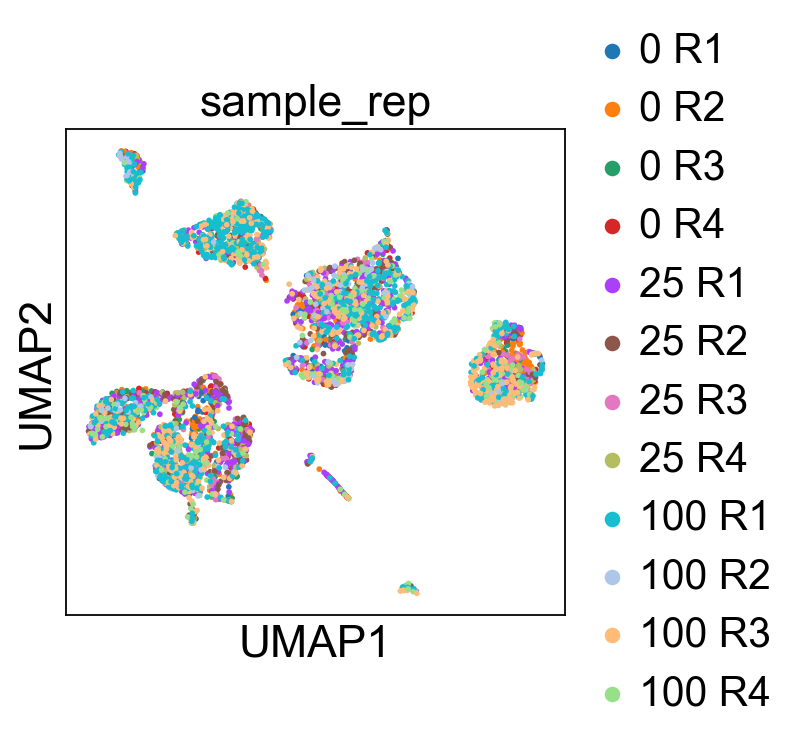

In [34]:
cpi.obs['sample_rep'] = build_samplerep(cpi, 'cond_continuous', 'replicate')
sc.pl.umap(cpi, color='sample_rep')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


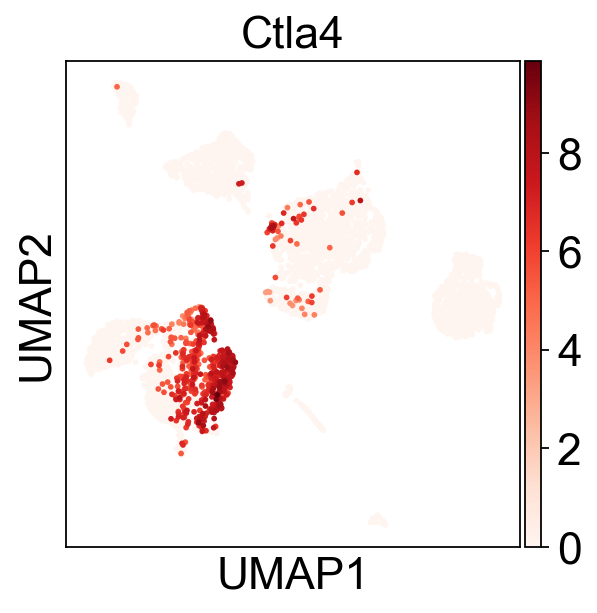

In [35]:
sc.pl.umap(cpi, color='Ctla4', cmap='Reds')

In [36]:
milo.make_nhoods(cpi, prop = 0.1)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51.37230682 40.04061127 34.99027634 41.24837875 29.0946331  49.27550125
 28.76835823 44.89975357 47.33308792 50.54209137 44.59682846 43.6493988
 45.30471802 54.04887009 47.48248291 35.0171814  51.57121277 62.42506027
 31.33952713 35.08721542 33.01577759 64.01105499 41.92250061 50.36213684
 51.27733231 35.33805847 27.10466576 33.3683548  40.7245369  52.38090515
 31.87927628 47.85712814 43.32094193 33.99776077 34.27385712 34.52157593
 35.888237   35.31077957 57.14532852 49.24188614 40.54135895 37.29843521
 48.1304245  50.79575729 37.66970062 62.13816833 39.9607811  30.78430557
 50.52238083 45.21851349 47.25521469 32.26377487 41.46524429 52.02319717
 47.85900879 40.97094345 43.13230896 43.14375687 51.32902527 48.67230988
 40.963871   30.91978073 36.14505005 70.58979034 40.01944733 28

In [38]:
cpi.obsm['nhoods']

<4497x365 sparse matrix of type '<class 'numpy.float32'>'
	with 9854 stored elements in Compressed Sparse Row format>

In [39]:
cpi[cpi.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AACCATGCATGAAGTA-1-BD2-0,1,51.372307
AAGTCTGGTACAGCAG-1-BD2-0,1,40.040611
ACACTGATCATCTGCC-1-BD2-0,1,34.990276
ACCCACTAGCCAACAG-1-BD2-0,1,41.248379
ACGCCAGAGATGCCTT-1-BD2-0,1,29.094633
...,...,...
TTCTTAGTCTCTTATG-1-BD4-1,1,51.994110
TTTACTGAGGTGATTA-1-BD4-1,1,43.066406
TTTACTGCATGCTGGC-1-BD4-1,1,39.560173
TTTCCTCAGACACTAA-1-BD4-1,1,36.226959


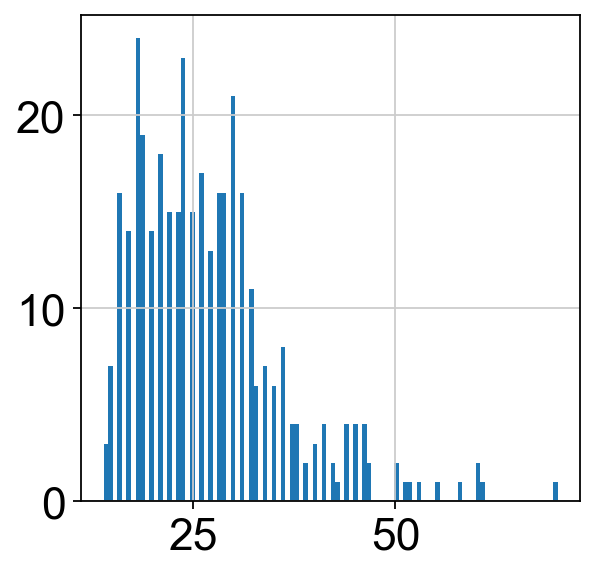

In [41]:
nhood_size = np.array(cpi.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [42]:
cpi.obs['rep_code'] = cpi.obs['sample_rep'].cat.codes
milo.count_nhoods(cpi, sample_col="rep_code")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [43]:
milo.DA_nhoods(cpi, design="~ cond_continuous")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:306: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:307: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [44]:
milo_results = cpi.uns["nhood_adata"].obs

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


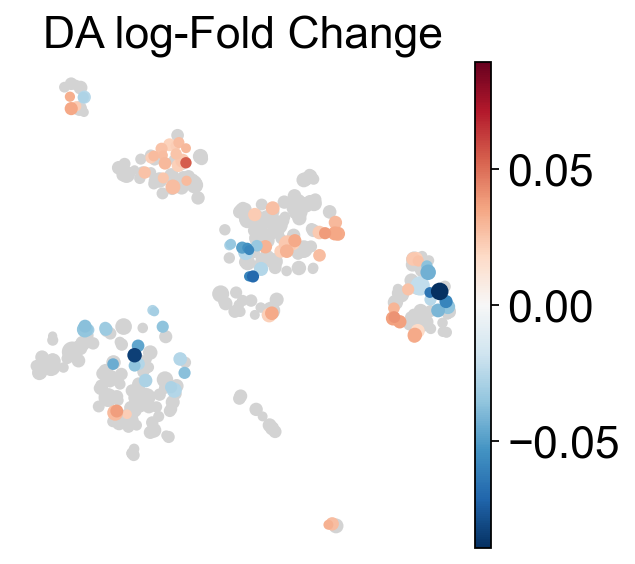

<Figure size 320x320 with 0 Axes>

In [45]:
milopy.utils.build_nhood_graph(cpi)
milopy.plot.plot_nhood_graph(cpi, alpha=0.1, min_size=5)
plt.tight_layout()

In [46]:
milopy.utils.annotate_nhoods(cpi, anno_col='celltype')

Text(0.5, 0, 'celltype fraction')

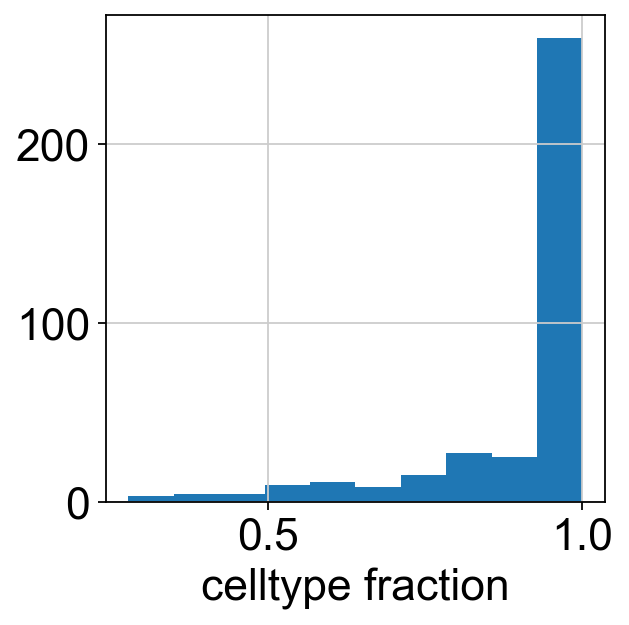

In [47]:
plt.hist(cpi.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("celltype fraction")

In [59]:
cpi.uns['nhood_adata'].obs['nhood_annotation_frac']

0      1.000000
1      0.812500
2      0.967742
3      0.953488
4      1.000000
         ...   
360    1.000000
361    0.789474
362    1.000000
363    1.000000
364    0.700000
Name: nhood_annotation_frac, Length: 365, dtype: float32

In [60]:
cpi.uns['nhood_adata'].obs.loc[cpi.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"


TypeError: Cannot setitem on a Categorical with a new category (Mixed), set the categories first

In [61]:
print(cpi.uns['nhood_adata'].obs['nhood_annotation'].cat.categories)

Index(['Basophil', 'CCR7+ DC', 'CD4+ T cell', 'CD8+ T cell', 'Fibroblast',
       'Macrophage', 'NK cell', 'Neutrophil', 'Poorly classified', 'Treg',
       'Tumor cell', 'XCR1+ DC', 'cDC2'],
      dtype='object')


In [62]:
if 'Mixed' not in cpi.uns['nhood_adata'].obs['nhood_annotation'].cat.categories:
    cpi.uns['nhood_adata'].obs['nhood_annotation'] = cpi.uns['nhood_adata'].obs['nhood_annotation'].cat.add_categories('Mixed')

In [63]:
cpi.uns['nhood_adata'].obs.loc[cpi.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.5, "nhood_annotation"] = "Mixed"


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


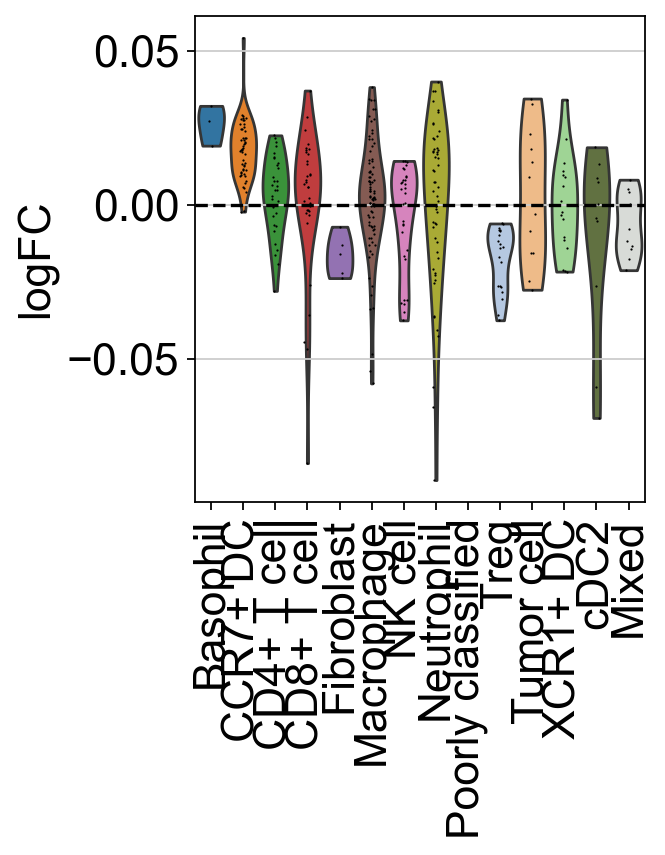

In [64]:
sc.pl.violin(cpi.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False, palette=celltype_dict)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [67]:
from community import community_louvain
import networkx as nx

test_adj2 = group_nhoods(cpi, 3, 0.6)
G_test1 = nx.from_numpy_array(test_adj2)
partition = community_louvain.best_partition(G_test1)
print(np.max(list(partition.values())))

26


/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/828529630.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

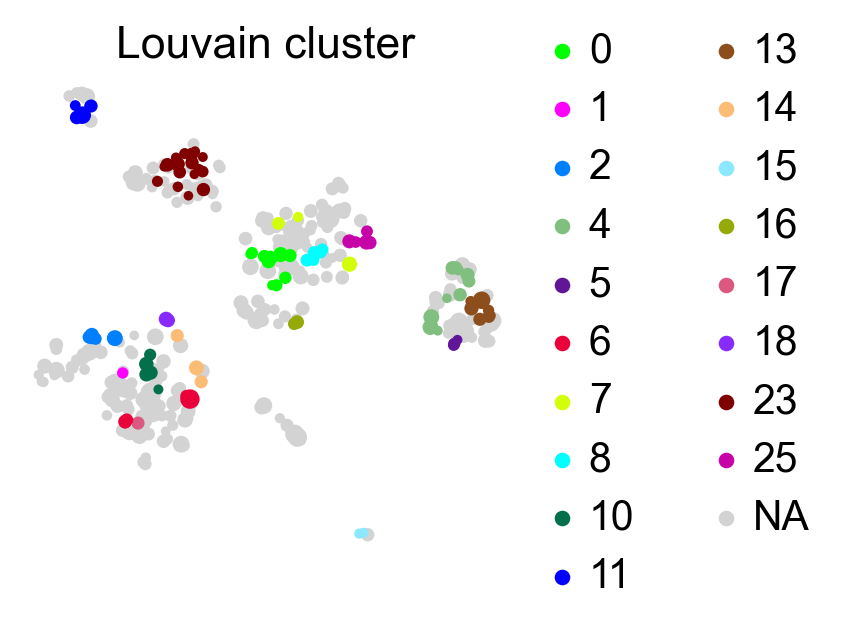

<Figure size 320x320 with 0 Axes>

In [68]:
louvain_lab0, louvain_pal0 = plot_nhood_clusters(cpi, list(partition.values()), 'Louvain cluster', alpha=0.1, min_size=5)
plt.tight_layout()

In [70]:
cpi.uns['nhood_adata'].obs['louvain'] = louvain_lab0
louvain_order = np.array([0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 23, 25])

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


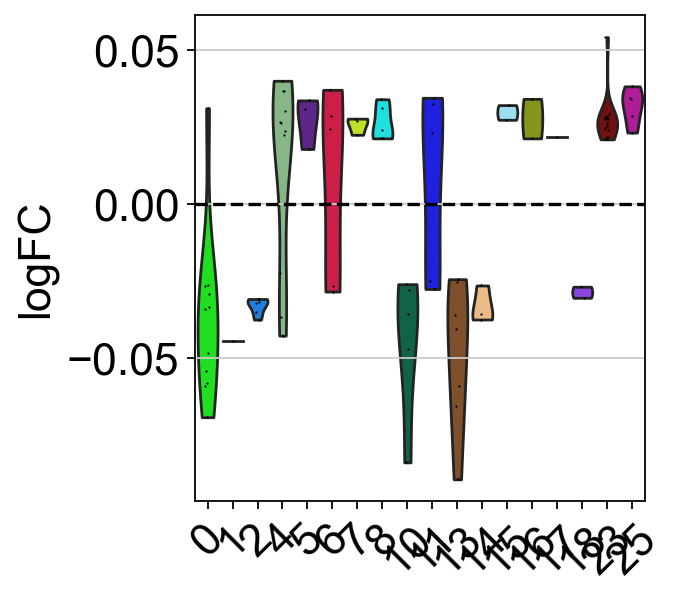

In [73]:
sc.pl.violin(cpi.uns['nhood_adata'], "logFC", groupby="louvain", hue = "louvain", legend = False, show=False, palette=louvain_pal0,
             order=louvain_order, rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [74]:
cpi.obs['sc_louvain'] = get_sc_louvain(cpi)
cpi.obs['sc_louvain'] = cpi.obs['sc_louvain'].astype('category')
cpi.obs['louvain_str'] = list(map(str, cpi.obs['sc_louvain'].values))

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3677228235.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 80)` for the same effect.

  sns.barplot(data=plot_df, x="sample", y="single cells", ci=80, capsize=.2,
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3677228235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="sample", y="single cells", ci=80, capsize=.2,
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3677228235.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 80)` for the same effect.

  sns.barplot(data=plot_df, x="sample", y="single cells", ci=80, capsize=.2,
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_12633/3677228235.py:9: FutureWarning: 

Passing `palette` without assigning `hue` i

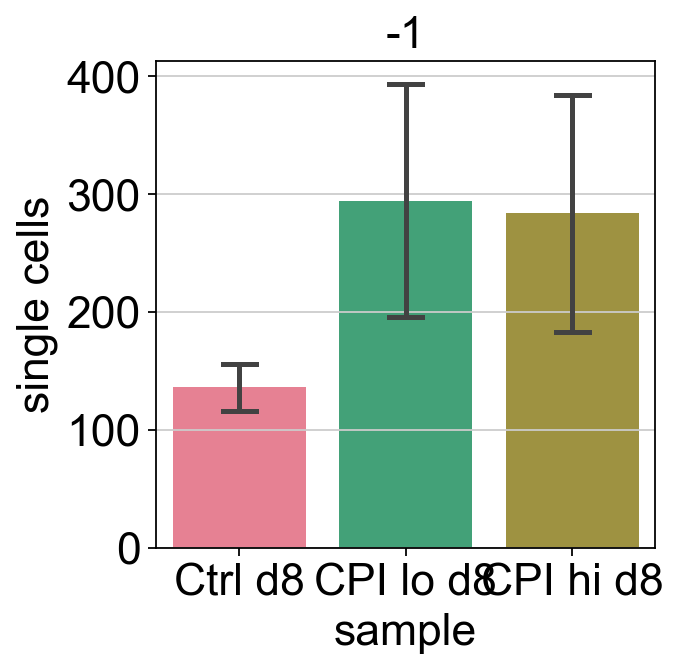

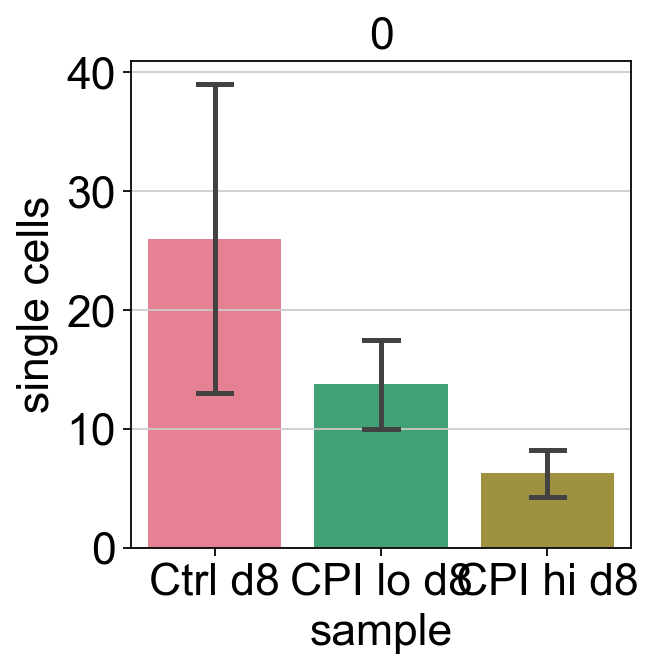

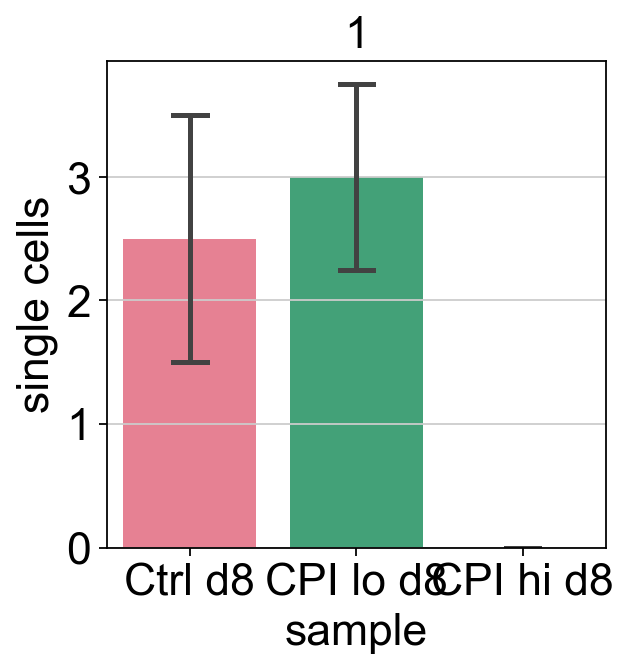

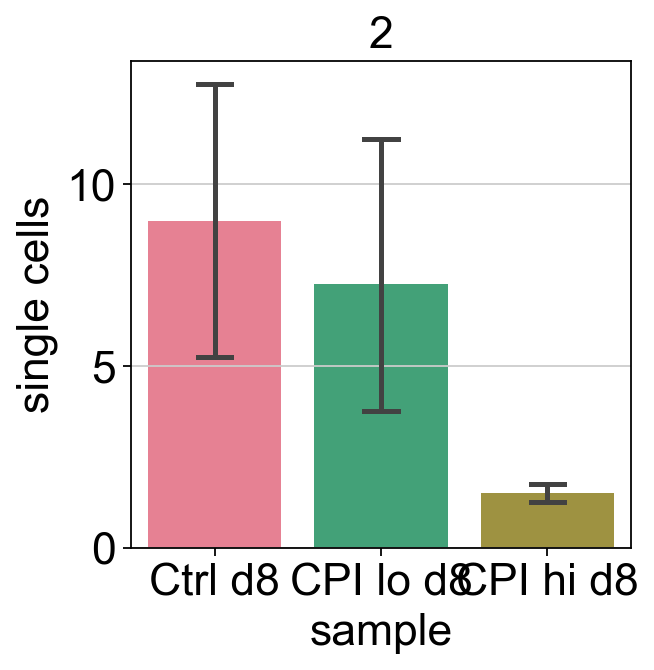

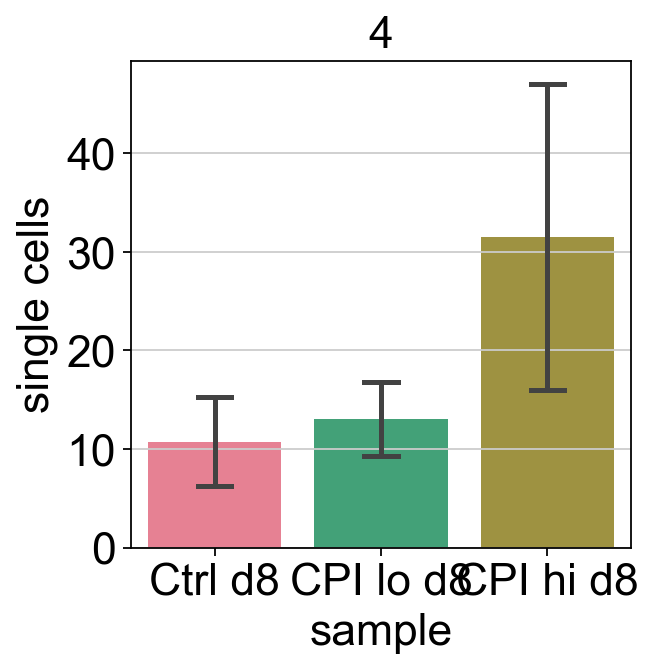

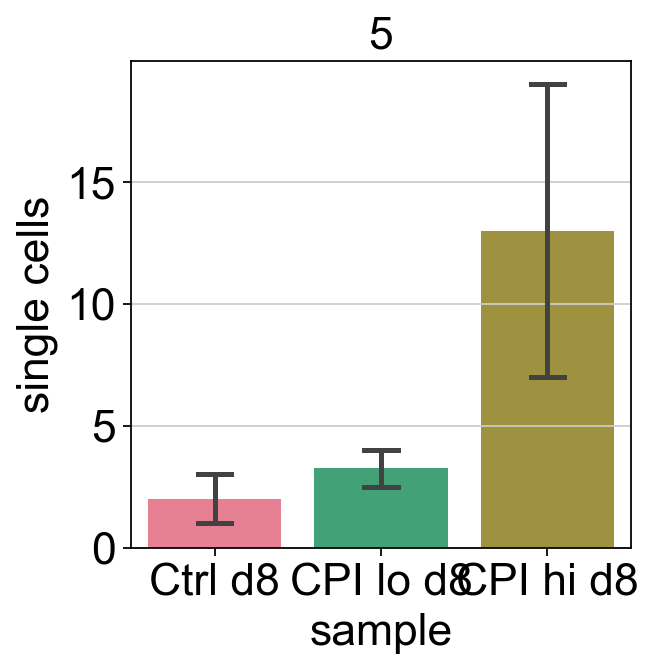

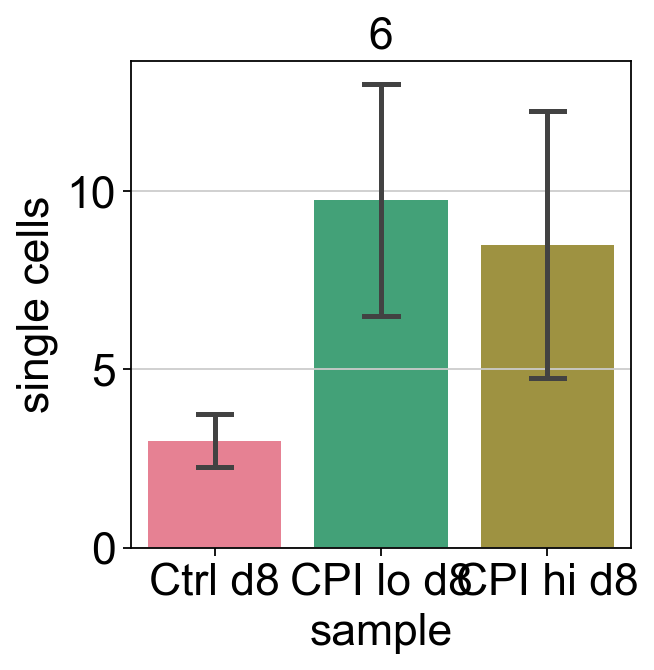

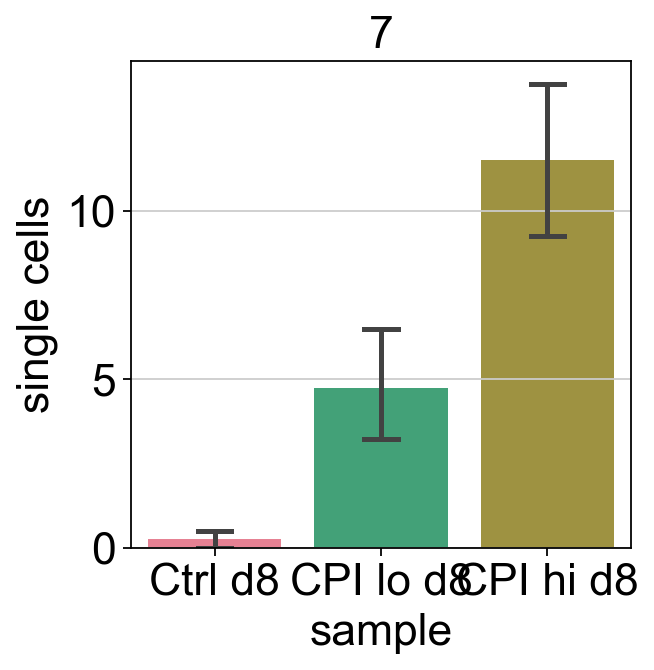

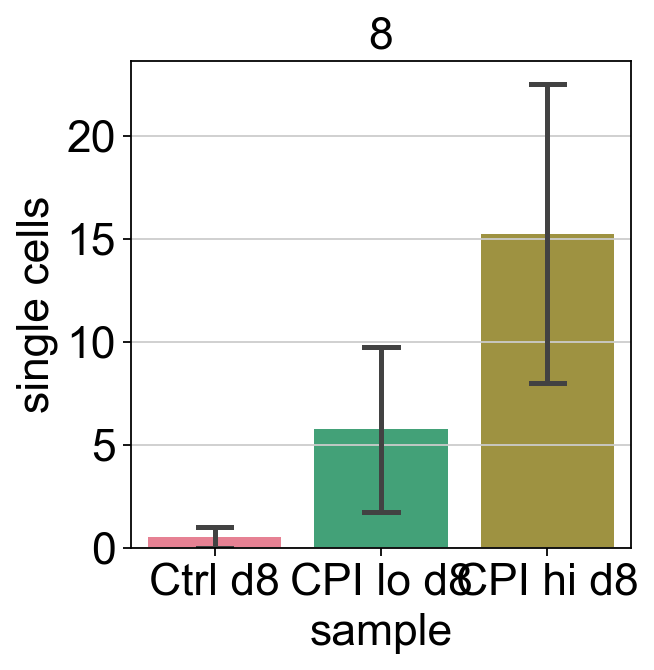

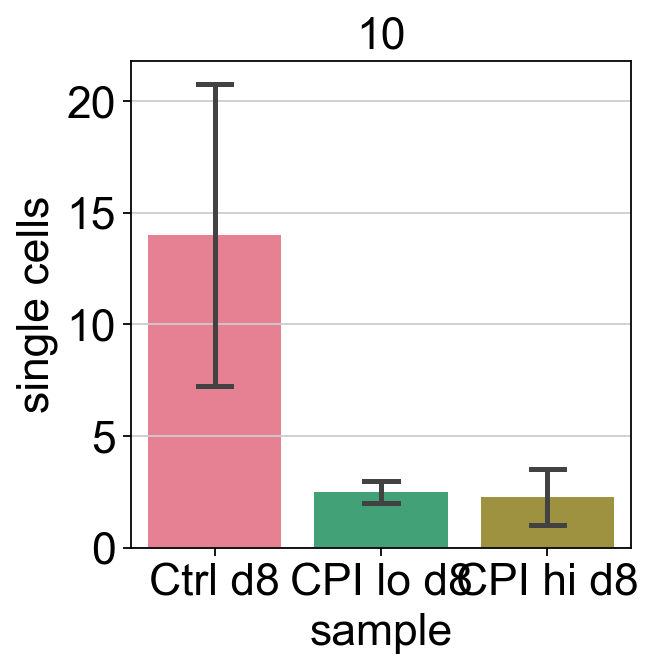

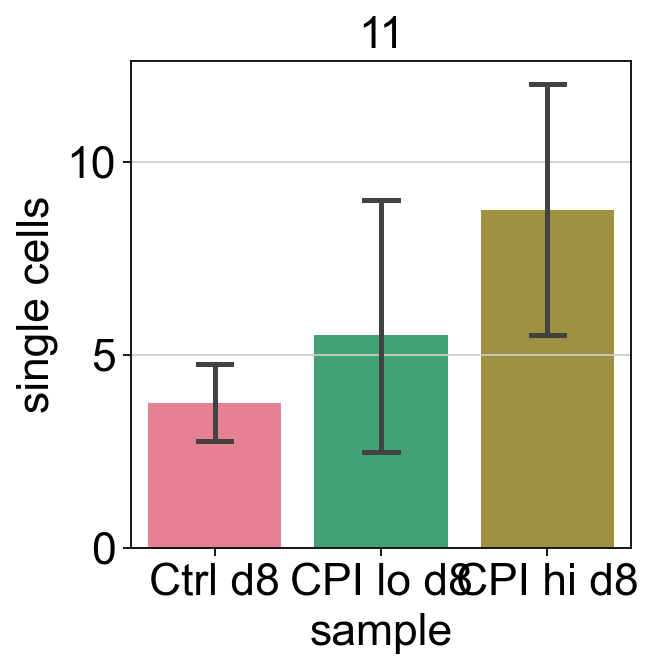

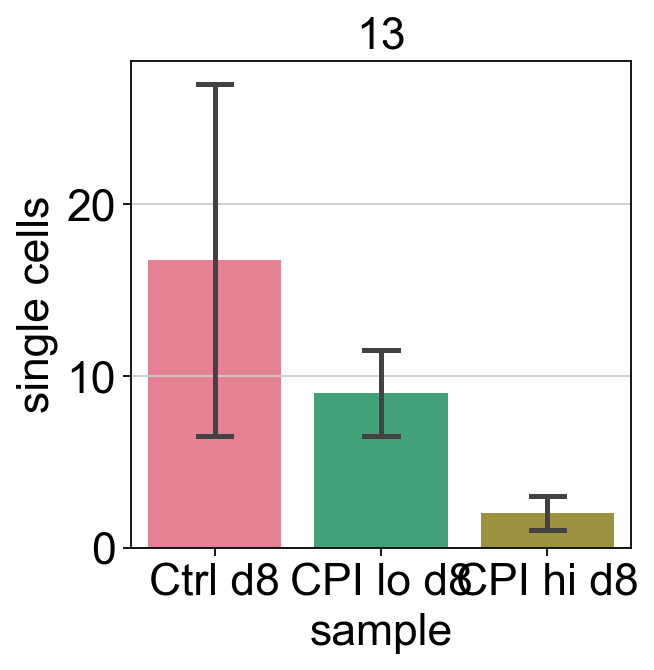

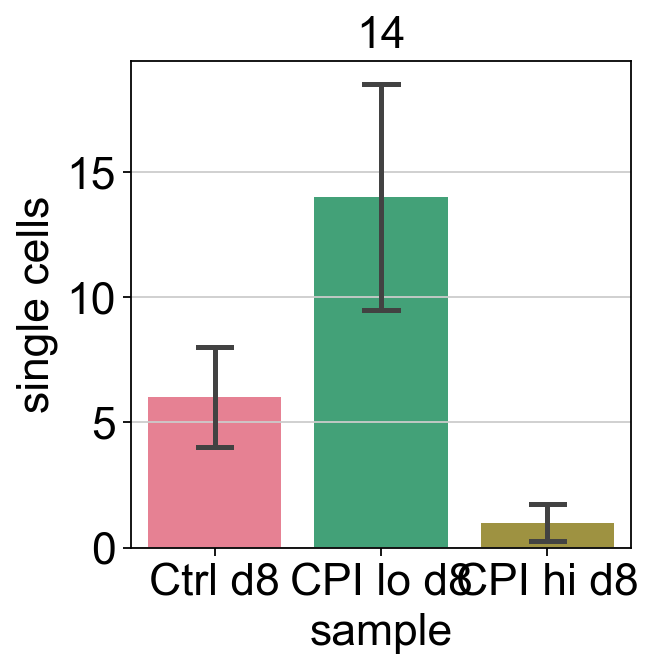

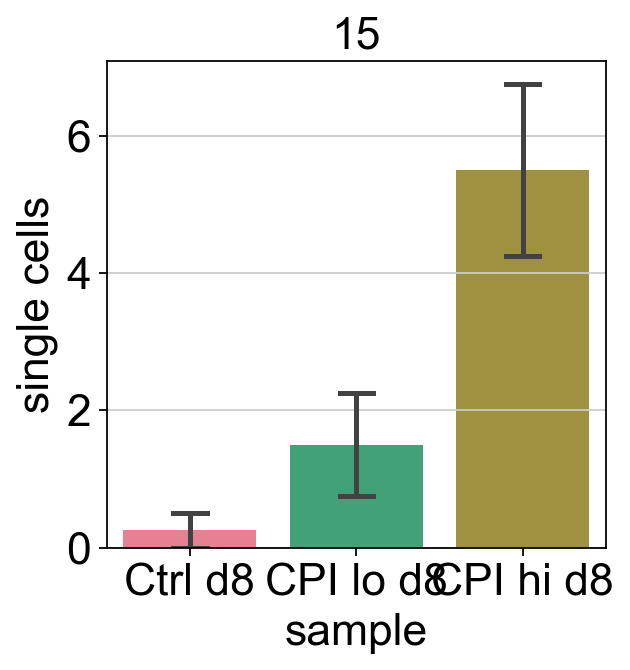

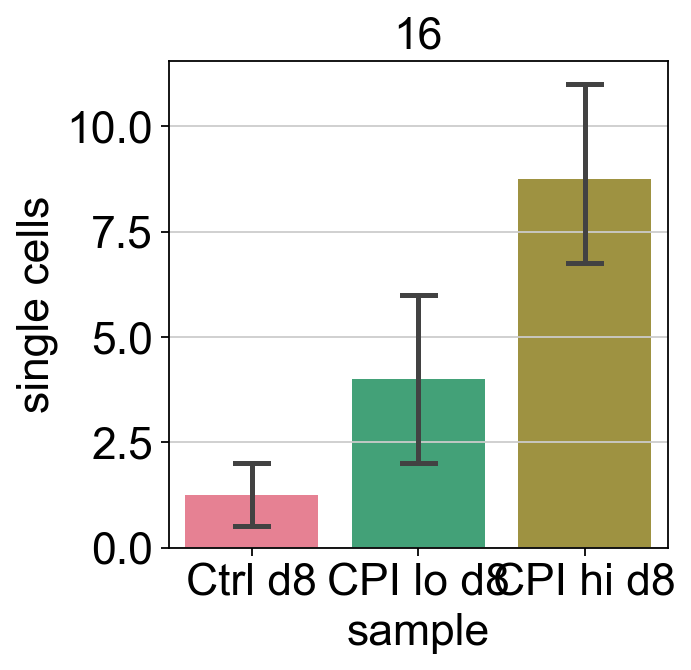

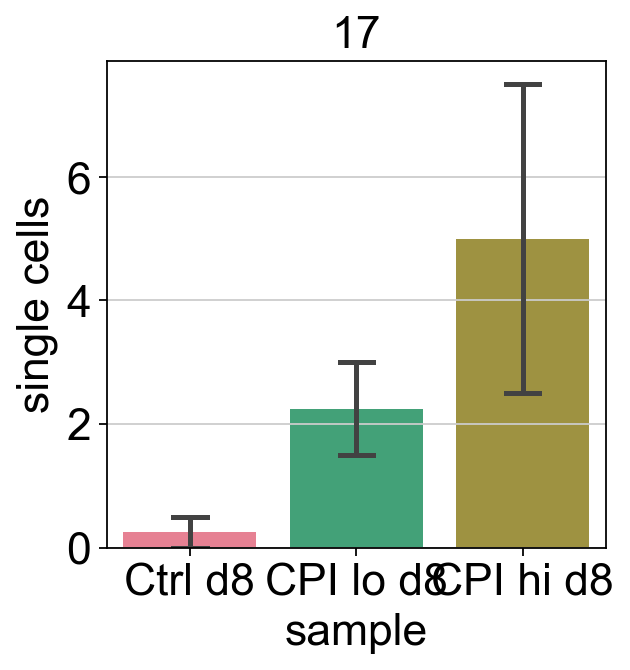

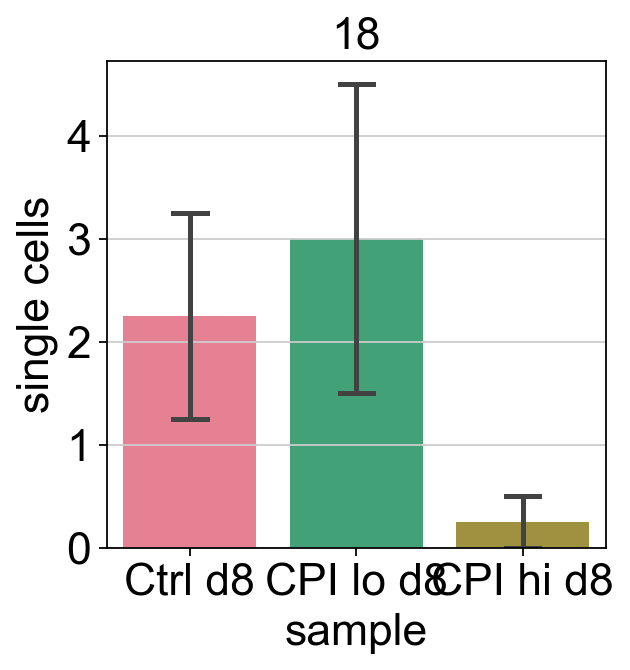

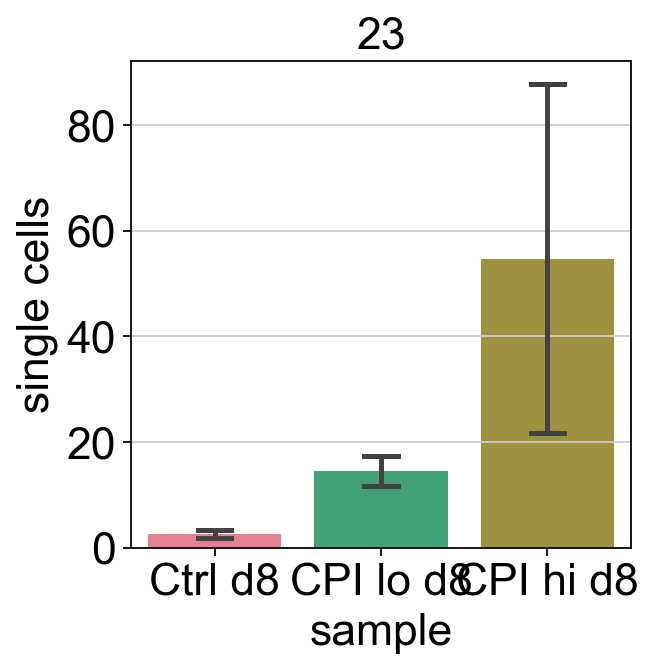

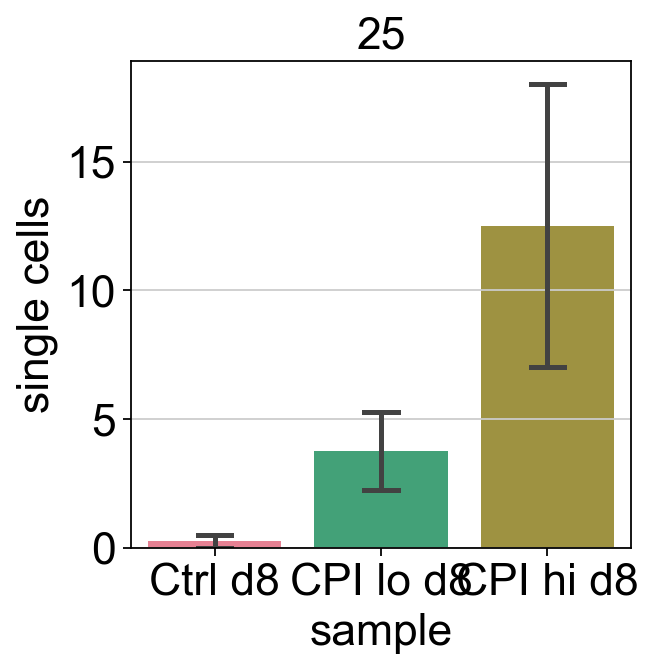

In [75]:
corr_ind = [0, 1, 2, 3, 8, 9, 10, 11, 4, 5, 6, 7]
cat = ['Ctrl d8', 'Ctrl d8', 'Ctrl d8', 'Ctrl d8', 'CPI lo d8', 'CPI lo d8', 'CPI lo d8', 'CPI lo d8',
       'CPI hi d8', 'CPI hi d8', 'CPI hi d8', 'CPI hi d8']
for f in np.unique(cpi.obs['sc_louvain']):
    clust = cpi[cpi.obs['sc_louvain'] == f]
    counts = [len(np.where(clust.obs['sample_rep'] == j)[0]) for j in np.unique(cpi.obs['sample_rep'])[corr_ind]]
    plot_df = pd.DataFrame({'sample': cat, 'single cells': counts})
    plt.figure()
    sns.barplot(data=plot_df, x="sample", y="single cells", ci=80, capsize=.2,
                palette=sample_dict).set_title(f)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


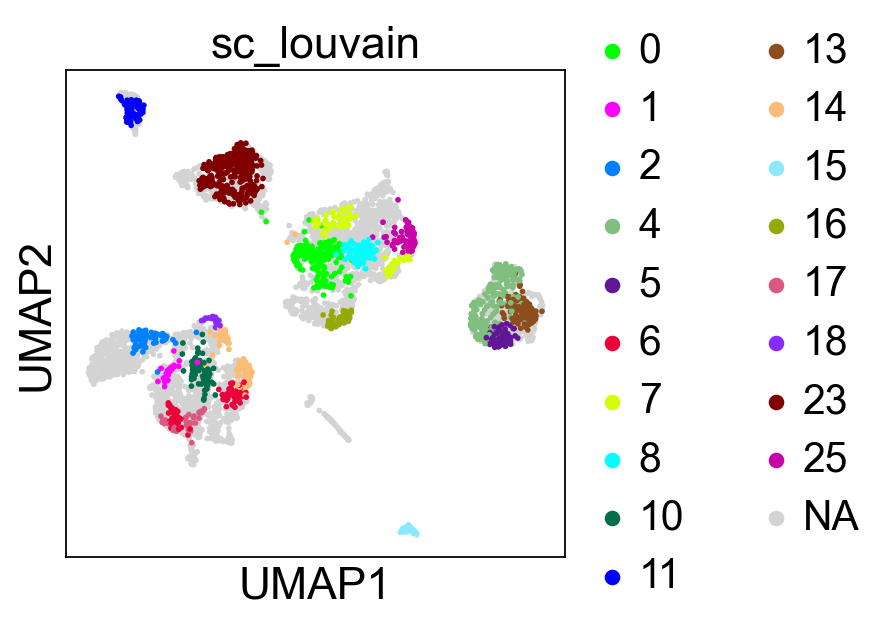

In [76]:
louvain_pal0.update({int(-1): "xkcd:light grey"})  # adding non-clustered cells to palette
sc.pl.umap(cpi, color='sc_louvain', palette=louvain_pal0, groups=np.unique(cpi.obs['sc_louvain'])[1:].tolist())

In [99]:
np.where(cpi.uns['nhood_adata'].obs.logFC < 0)

(array([  0,   1,   2,   3,   4,   5,   8,  10,  11,  12,  13,  14,  15,
         16,  17,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  33,  34,  35,  36,  37,  38,  39,  40,  41,  43,  44,  45,
         46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  63,  64,  65,  66,  68,  70,  71,  74,  76,  81,
         84,  85,  88,  91,  92,  93,  97,  98, 105, 107, 110, 112, 114,
        119, 121, 123, 125, 126, 128, 130, 131, 132, 133, 135, 136, 138,
        139, 140, 141, 143, 147, 151, 152, 153, 154, 155, 157, 158, 159,
        164, 166, 171, 174, 175, 177, 178, 181, 182, 185, 188, 190, 191,
        194, 195, 196, 197, 198, 199, 200, 202, 203, 216, 246, 250, 252,
        264, 265, 266, 268, 270, 277, 289, 299, 305, 312, 318, 320, 321,
        339, 352, 361]),)

In [101]:
cpi.uns['nhood_adata'].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Nhood_size,nhood_annotation,nhood_annotation_frac,louvain
0,AACCATGCATGAAGTA-1-BD2-0,51.372307,-0.029325,12.721512,8.077169,0.004508,0.035853,0.034697,31.0,Macrophage,1.000000,0
1,AAGTCTGGTACAGCAG-1-BD2-0,40.040611,-0.002016,12.167535,0.037561,0.846338,0.919204,0.919559,16.0,CD8+ T cell,0.812500,NaN
2,ACACTGATCATCTGCC-1-BD2-0,34.990276,-0.014657,12.598334,2.280824,0.131069,0.283078,0.276699,31.0,NK cell,0.967742,NaN
3,ACCCACTAGCCAACAG-1-BD2-0,41.248379,-0.014996,12.876046,2.640456,0.104260,0.247110,0.239944,43.0,Macrophage,0.953488,NaN
4,ACGCCAGAGATGCCTT-1-BD2-0,29.094633,-0.042770,12.534761,12.477346,0.000417,0.008935,0.008391,26.0,Neutrophil,1.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
360,TTCTTAGTCTCTTATG-1-BD4-1,51.994110,0.007484,12.112838,0.526880,0.467968,0.632623,0.627261,17.0,Macrophage,1.000000,NaN
361,TTTACTGAGGTGATTA-1-BD4-1,43.066406,-0.003749,12.224439,0.142537,0.705794,0.817825,0.813158,19.0,CD4+ T cell,0.789474,NaN
362,TTTACTGCATGCTGGC-1-BD4-1,39.560173,0.026033,12.264091,7.076888,0.007843,0.048518,0.046785,24.0,CCR7+ DC,1.000000,23
363,TTTCCTCAGACACTAA-1-BD4-1,36.226959,0.024545,12.590046,6.974224,0.008304,0.048889,0.047374,34.0,CCR7+ DC,1.000000,23


In [93]:
np.where(cpi.uns['nhood_adata'].obs.logFC == 0)

(array([], dtype=int64),)

In [90]:
np.where(cpi.uns['nhood_adata'].obs.logFC > 0)

(array([  6,   7,   9,  18,  31,  32,  42,  62,  67,  69,  72,  73,  75,
         77,  78,  79,  80,  82,  83,  86,  87,  89,  90,  94,  95,  96,
         99, 100, 101, 102, 103, 104, 106, 108, 109, 111, 113, 115, 116,
        117, 118, 120, 122, 124, 127, 129, 134, 137, 142, 144, 145, 146,
        148, 149, 150, 156, 160, 161, 162, 163, 165, 167, 168, 169, 170,
        172, 173, 176, 179, 180, 183, 184, 186, 187, 189, 192, 193, 201,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 247, 248, 249, 251, 253, 254, 255, 256, 257, 258, 259,
        260, 261, 262, 263, 267, 269, 271, 272, 273, 274, 275, 276, 278,
        279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 292,
        293, 294, 295, 296, 297, 298, 300, 301, 302, 303, 304, 306, 307,
        308, 309, 310, 311, 313, 314, 315, 316, 317

In [102]:
import muon as mu
from muon import prot as pt
from mudata import MuData

In [1]:
cpi.obs['sample_rep']

NameError: name 'cpi' is not defined